# Theoretical analysis of the model

this is a WIP, translation from a python script (`diagnotic.py`)

In [1]:
from os import mkdir, remove
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import sympy as sp

In [2]:
from tests.test_disk_physics import r, r_range, my_model, my_model_prime,\
    ref_length, sample0, sample1, conf, usr, DTDisk, evaluate_disk_mass_ratio,\
    get_flaring

## definitions

In [3]:
center = my_model.get_value('r0')
sig = my_model.get_value('sig')

def eval_sample(f, sampler):
    r = sp.symbols('r')
    return np.array(list(map(lambda x: f.subs(r,x), sampler)))

def map_functions(functions:dict, sampler:list):
    ys = {}
    for k, func in functions.items():
        ys.update(
            { k : eval_sample(func, sampler) }
        )
    return ys

In [4]:
def local_upper_particle_size(model, R):
    '''Return maximum particle size for \rho_p = 1g/cm^3 at given radial position R.'''
    rho = model.midplane_volumic_density
    cs  = model.sound_speed
    OmK = model.keplerian_angular_velocity
    ups = (cs * rho / OmK).subs(DTDisk.r,R) * sp.sqrt(2/sp.pi) / model.values[DTDisk.rhop]
    return ups.evalf()

def global_upper_particle_size(model, r_range):
    #In practice, often useless because for most models, the minimal
    #value of this function is given at either one of the boundaries.
    ups = 1.0
    for r in r_range:
        ups = min(ups, local_upper_particle_size(model, r))
    return ups

In [5]:
#This mess is hard to understand and should be refactored
fs0 = {
    'rayleigh': my_model.rayleigh_function,
    'density' : my_model.surface_density,
    'omega'   : my_model.angular_velocity,
}
ys0 = map_functions(fs0, sample0)

fs1 = {
    'lovelace' : my_model.lovelace_function,
    'dlovelace': my_model.lovelace_function.diff(r),
}
ys1 = map_functions(fs1, sample1)

## Quick physical diagnostics of the model

In [6]:
def mess(desc:str, val:float, crit:bool) -> str:
    res = {True: "OK", False: "KO"}
    return desc.ljust(40) + f"{val:.3e}".ljust(20) + res[crit]

disk_mass = evaluate_disk_mass_ratio(conf, my_model_prime)
Q = my_model.toomre_number.subs(r,center+sig).evalf(3)
flare = get_flaring(my_model.values[DTDisk.slope], my_model.values[DTDisk.gamma])

print("Desc                                    val                 crit")
print("----------------------------------------------------------------")
print(mess("early disk/star mass ratio", disk_mass, disk_mass<0.04))
print(mess("typical Toomre's Q", Q, Q>1))
print(mess("effective flaring index", flare, flare < 1.0))

Desc                                    val                 crit
----------------------------------------------------------------
early disk/star mass ratio              9.459e-3            OK
typical Toomre's Q                      2.770e+1            OK
effective flaring index                 8.330e-01           OK


## Density profile

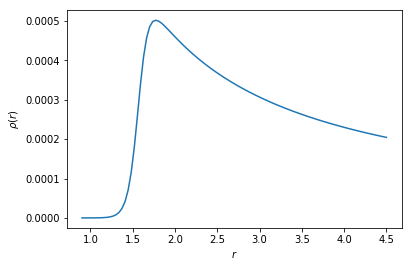

In [7]:
fig, ax = plt.subplots(num=1)

ax.plot(sample0, ys0['density'])
ax.set_ylabel(r'$\rho(r)$')
ax.set_xlabel(r'$r$')

plt.show()

## Rayleigh stability (if 'rayleigh' function is >0)

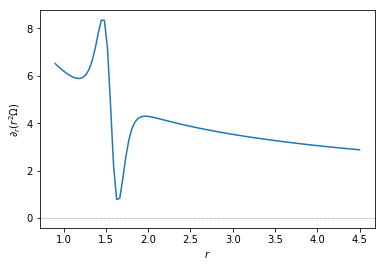

In [8]:
fig, ax = plt.subplots(num=2)
ax.plot(sample0, ys0['rayleigh'])
ax.set_ylabel(r'$\partial_r (r^2\Omega)$')
xlims = ax.get_xlim()
ax.plot(np.linspace(*xlims, 2), np.zeros(2), ls=':', lw=0.5, c='k')
ax.set_xlim(xlims)
ax.set_xlabel(r'$r$')

plt.show()

## RWI instability (if there's an extremum in Lovelace function)

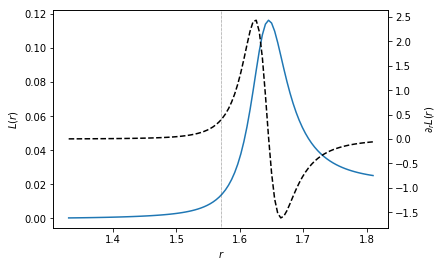

In [9]:
fig, ax = plt.subplots(num=3)

ax.plot(sample1, ys1['lovelace'])
axt = ax.twinx()
axt.plot(sample1, ys1['dlovelace'], ls='--', c='k')
ax.set_ylabel(r'$L(r)$')
axt.set_ylabel(r'$\partial_r L(r)$')


#mark the cavity location and add legends
ylims = ax.get_ylim()
ax.plot(usr['cavity_radius']*np.ones(2), np.linspace(*ylims, 2), ls=':', lw=0.5, c='k')
ax.set_ylim(*ylims)
ax.set_xlabel(r'$r$')

plt.show()

## Hersant's criterion for Stokes numbers

/beegfs/home/crobert/local/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3370: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  self.set_ylim(upper, lower, auto=None)


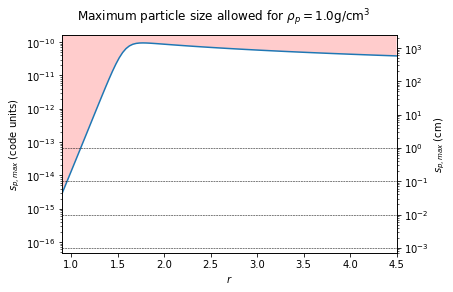

maximum grain size at cavity radius 5.53794260700685E-11 (code units)


In [10]:
fig,ax = plt.subplots(num=4)
val = '%.1f' % conf['usr_dust_list']['grain_density_gcm3']
fig.suptitle(r'Maximum particle size allowed for $\rho_p='+val+r'$g/cm$^3$')

lups = np.zeros(len(r_range))
for i,rad in enumerate(r_range):
    lups[i] = local_upper_particle_size(my_model, rad)
ax.plot(r_range, lups)
ax.set_yscale('log')
ax.set_xlabel('$r$')
ax.set_ylabel('$s_{p,max}$ (code units)')


ax.set_xlim(*xlims)
ylims = ax.get_ylim()
ax.fill_between(r_range, ylims[1]*np.ones(len(lups)), lups, facecolor='red', alpha=0.2)
ax.set_ylim(*ylims)
ax.set_xlim(r_range.min(), r_range.max())

#twin axis with physical unit
axb = ax.twinx()
axb.set_yscale('log')
axb.set_ylabel('$s_{p,max}$ (cm)')

#add lines where actual grains are used
xlims = ax.get_xlim()
for grain_size in conf["usr_dust_list"]["grain_size_cm"]:
    axb.plot(np.linspace(*xlims,2), grain_size*np.ones(2), ls='--', c='k', lw=0.5)


# correct ylims
ylims_base = np.array(ax.get_ylim()) * ref_length
ylims_phys = axb.get_ylim()
my_ylims_phys = np.array([min(ylims_base[0], ylims_phys[0]), max(ylims_base[1], ylims_phys[1])])
axb.set_ylim(*my_ylims_phys)
ax.set_ylim(*(my_ylims_phys /ref_length))



plt.show()

spmax = local_upper_particle_size(my_model, usr['cavity_radius'])
print(f'maximum grain size at cavity radius {spmax} (code units)')

# Initial Stokes numbers (and Hersant criterion)

this is a display of the same information as the previous graph, only in a different view

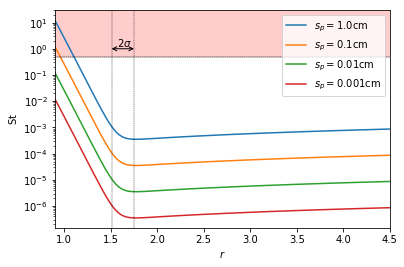

In [11]:
fig,ax = plt.subplots(num=4)
#fig.suptitle(r'''Initial Stokes number VS (Hersant 2009) criterion.
#the $2\sigma$ wide region around the bump is displayed''')

sizes = conf['usr_dust_list']['grain_size_cm']
if isinstance(sizes, float): sizes = [sizes]

for grain_size in sizes:
    St = np.zeros(len(r_range))
    my_model.values[DTDisk.sp] = grain_size / ref_length
    for i,rv in enumerate(r_range):
        St[i] = my_model.stokes_number.subs(r, rv)
    ax.plot(r_range, St, label=f'$s_p={grain_size}$cm')
ax.set_yscale('log')
ax.plot(r_range, 0.5*np.ones(len(r_range)), color='k', lw=0.2)

ylims = ax.get_ylim()
ax.fill_between(
    r_range,
    ylims[1]*np.ones(len(r_range)),
    0.5*np.ones(len(r_range)),
    alpha=0.2,
    facecolor='red'
)


# Annotate the cavity transition region within 2 sigma
asymp = dict(ls='--', c='k', lw=0.4)
ax.plot(r_range, r_range/r_range*0.5, **asymp)
sigmm = (center-sig/2)
sigpp = (center+3*sig/2)
ax.plot(sigmm*np.ones(2), np.array(ylims), **asymp)
ax.plot(sigpp*np.ones(2), np.array(ylims), **asymp)

ax.annotate(s=r'', xy=(sigmm,1), xytext=(sigpp,1),
            arrowprops=dict(arrowstyle='<->', shrinkA=0, shrinkB=0))
ax.annotate(s=r'$2\sigma$', xy=(center, 1.2))


ax.set_xlabel(r'$r$')
ax.set_ylabel(r'$\mathrm{St}$')
ax.set_ylim(ylims)
ax.set_xlim(r_range.min(), r_range.max())
ax.legend(loc="upper right")

plt.show()

## Toomre (self gravity)

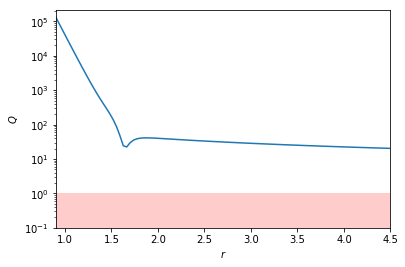

In [12]:
fig,ax = plt.subplots(num=5)
#fig.suptitle('Initial Toomre number $Q$ (SGI excpected where $Q < 1$)')

Q = np.zeros(len(r_range))
for i,rv in enumerate(r_range):
    Q[i] = my_model.toomre_number.subs(r, rv)
ax.plot(r_range, Q, label='$Q$ model')
ax.set_yscale('log')
ylims = ax.get_ylim()
ax.set_xlabel(r'$r$')
ax.set_ylabel(r'$Q$')

ylims = list(ax.get_ylim())
ylims[0] = 1e-1
ax.fill_between(r_range, np.ones(len(r_range)), ylims[0]*np.ones(len(r_range)), alpha=0.2, facecolor='red')
ax.set_ylim(*ylims)
ax.set_xlim(r_range[0], r_range[-1])

plt.show()

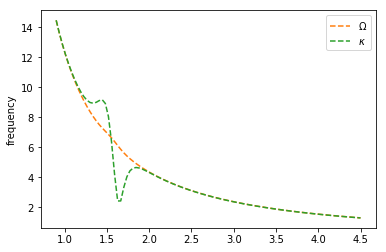

In [13]:
## Frequencies (rotational, epicyclic)

fig, ax = plt.subplots(num=6)

omega = np.zeros(len(r_range))
kappa = np.zeros(len(r_range))
for i,rv in enumerate(r_range):
    omega[i] = my_model.angular_velocity.subs(r, rv)
    kappa[i] = my_model.epicyclic_frequency.subs(r, rv)
ax.plot(r_range, omega, ls='--', lw=0)#skip a color
ax.plot(r_range, omega, ls='--', label=r'$\Omega$')
ax.plot(r_range, kappa, ls='--', label=r'$\kappa$')
ax.set_ylabel('frequency')
ax.legend()

plt.show()
#fig.savefig(str(out/'toomre.png'), bbox_tight=True)

## Reynolds numbers (dust)

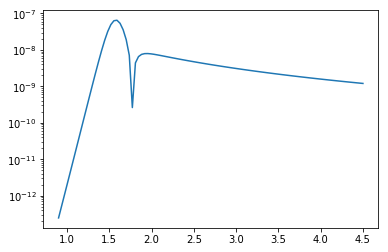

In [14]:
fig,ax = plt.subplots(num=3)
ax.plot(
    r_range,
    abs(eval_sample(my_model.dust_reynolds, r_range))
)

ax.set_yscale('log')
plt.show()
#fig.savefig(str(out/'dust_reynolds.png'), bbox_tight=True)